# UK Used Car Price Prediction

### Objective

To build a model to predict the value of used car prices within the UK market.

### Performance Measure

Root mean squared error (RMSE) as the preferred peformance measure for regression tasks.

In [127]:
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import FeatureHasher
from sklearn.compose import ColumnTransformer

## Import the data

In [149]:
# path to folder containing the data
folder_path = 'data'

# Intialise list to store each df
import_dfs = []

# Loop through each CSV file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Extract make from file name
        make = os.path.splitext(file_name)[0]
        # Read the CSV file into a DataFrame
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        # Add 'make' column to DataFrame
        df['make'] = make
        # Append the DataFrame to the list
        import_dfs.append(df)

# Combibe dfs into a single df
car_price_data = pd.concat(import_dfs, ignore_index=True)

#### Rename columns

In [150]:
car_price_data.rename(columns={'fuelType': 'fuel_type', 'tax': 'road_tax', 'engineSize': 'engine_size'},inplace=True)

#### Inspect Data

In [151]:
car_price_data.head()

,model,year,price,transmission,mileage,fuel_type,road_tax,mpg,engine_size,make
0,Corsa,2018,7885,Manual,9876,Petrol,145,55.4,1.4,vauxhall
1,Corsa,2019,11995,Manual,2500,Petrol,145,54.3,1.4,vauxhall
2,Corsa,2017,9777,Automatic,9625,Petrol,145,47.9,1.4,vauxhall
3,Corsa,2016,8500,Manual,25796,Petrol,30,55.4,1.4,vauxhall
4,Corsa,2019,10000,Manual,3887,Petrol,145,43.5,1.4,vauxhall


## Data Inspection

In [152]:
car_price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99187 entries, 0 to 99186
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99187 non-null  object 
 1   year          99187 non-null  int64  
 2   price         99187 non-null  int64  
 3   transmission  99187 non-null  object 
 4   mileage       99187 non-null  int64  
 5   fuel_type     99187 non-null  object 
 6   road_tax      99187 non-null  int64  
 7   mpg           99187 non-null  float64
 8   engine_size   99187 non-null  float64
 9   make          99187 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 7.6+ MB


In [153]:
car_price_data.describe()

,year,price,mileage,road_tax,mpg,engine_size
count,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000
mean,2017.087723,16805.347656,23058.914213,120.299838,55.166825,1.663280
std,2.123934,9866.773417,21148.523721,63.150926,16.138522,0.557646
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7425.000000,125.000000,47.100000,1.200000
50%,2017.000000,14495.000000,17460.000000,145.000000,54.300000,1.600000
75%,2019.000000,20870.000000,32339.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


Drop rows where year is in the future:

In [154]:
car_price_data = car_price_data[car_price_data['year'] <= 2024]

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'mileage'}>,
        <Axes: title={'center': 'road_tax'}>],
       [<Axes: title={'center': 'mpg'}>,
        <Axes: title={'center': 'engine_size'}>]], dtype=object)

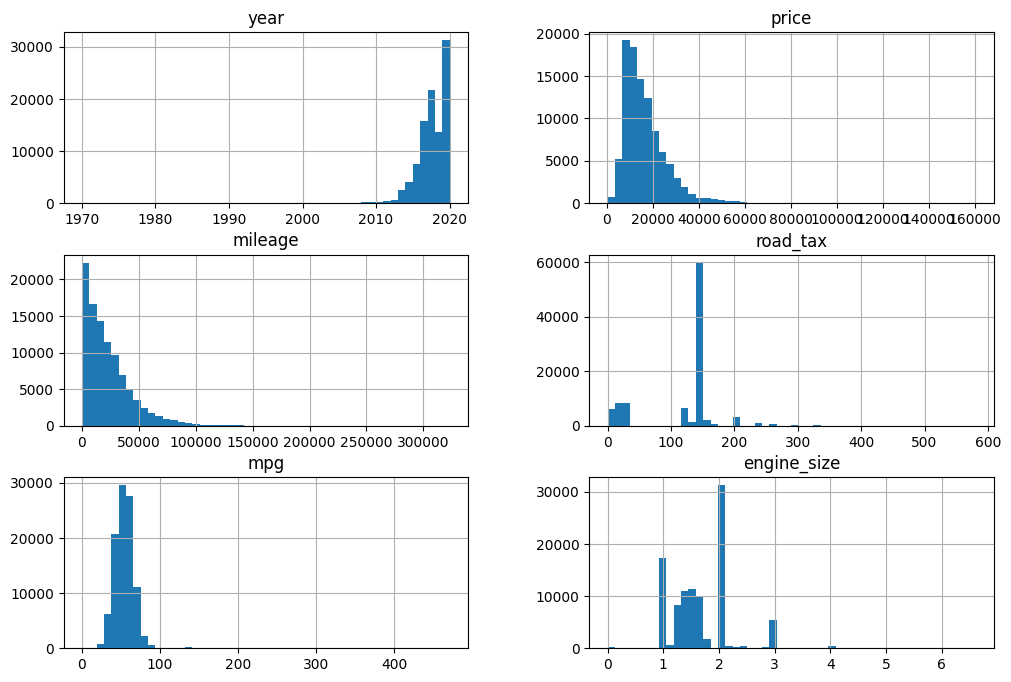

In [155]:
# Plot histograms for numerical features
car_price_data.hist(bins=50, figsize=(12,8))

#### Observations

1. The maximum value for year is 2060 - 36 years in the future - this will need to be addressed
2. There appears to be some outliers between 1970-2000 in the year feature
2. Road tax in the UK is banded, and so values it can take are discrete
2. Features have very different scaling - feature scaling would likely be beneficial
3. Price and MPG are skewed right - transforming these features would likely be beneficial (make symmetrical and bell-shaped distribution)

## Create Test Set

Use 80:20 train-test split.

In [156]:
train_set, test_set = train_test_split(
    car_price_data,
    test_size=0.2,
    random_state=42
)

## Exploratory Data Analysis (EDA)

In [157]:
# Create a copy of the train set for EDA
car_price_data_df = train_set.copy()

#### Correlation Matrix

In [158]:
# Create correlation matrix
corr_matrix = car_price_data_df.corr(numeric_only=True)

# Select correlation with price and sort by descending
corr_matrix['price'].sort_values(ascending=False)

price          1.000000
engine_size    0.639186
year           0.492495
road_tax       0.307222
mpg           -0.287797
mileage       -0.418272
Name: price, dtype: float64

<Axes: >

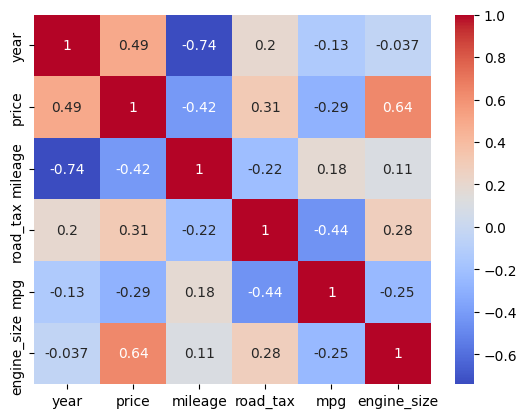

In [159]:
# Create heatmap with correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm',annot=True)

array([[<Axes: xlabel='year', ylabel='year'>,
        <Axes: xlabel='price', ylabel='year'>,
        <Axes: xlabel='mileage', ylabel='year'>,
        <Axes: xlabel='road_tax', ylabel='year'>,
        <Axes: xlabel='mpg', ylabel='year'>,
        <Axes: xlabel='engine_size', ylabel='year'>],
       [<Axes: xlabel='year', ylabel='price'>,
        <Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='mileage', ylabel='price'>,
        <Axes: xlabel='road_tax', ylabel='price'>,
        <Axes: xlabel='mpg', ylabel='price'>,
        <Axes: xlabel='engine_size', ylabel='price'>],
       [<Axes: xlabel='year', ylabel='mileage'>,
        <Axes: xlabel='price', ylabel='mileage'>,
        <Axes: xlabel='mileage', ylabel='mileage'>,
        <Axes: xlabel='road_tax', ylabel='mileage'>,
        <Axes: xlabel='mpg', ylabel='mileage'>,
        <Axes: xlabel='engine_size', ylabel='mileage'>],
       [<Axes: xlabel='year', ylabel='road_tax'>,
        <Axes: xlabel='price', ylabel='road_tax'>,
  

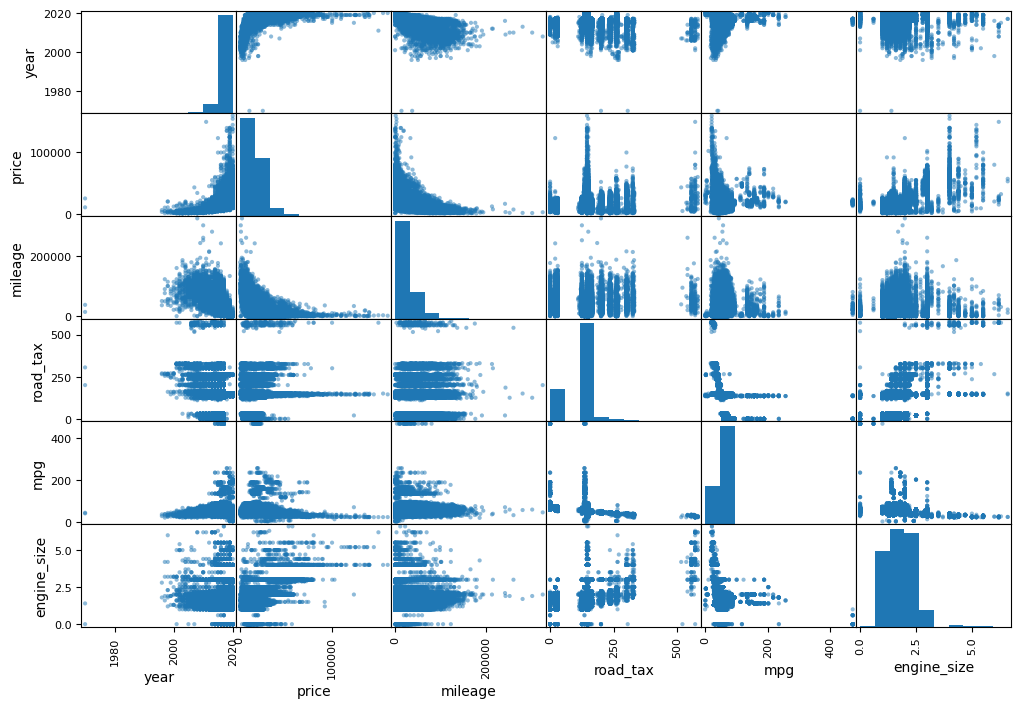

In [160]:
# Create scatter matrix
scatter_matrix(car_price_data, figsize=(12,8))

#### Zoom in on Year and Mileage Correlations

<Axes: xlabel='year', ylabel='price'>

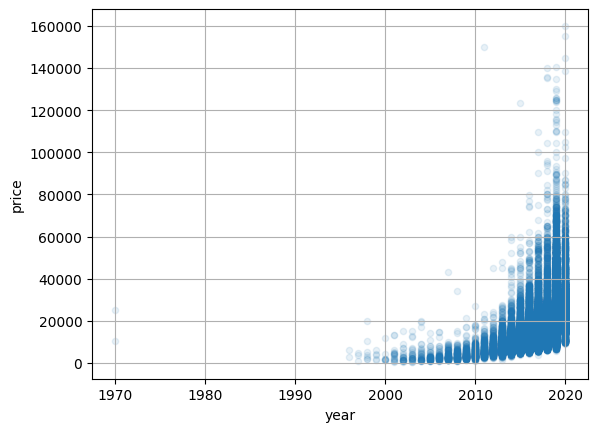

In [163]:
car_price_data_df.plot(
    kind='scatter', 
    x='year', 
    y='price',
    alpha=0.1,
    grid=True
)

<Axes: xlabel='mileage', ylabel='price'>

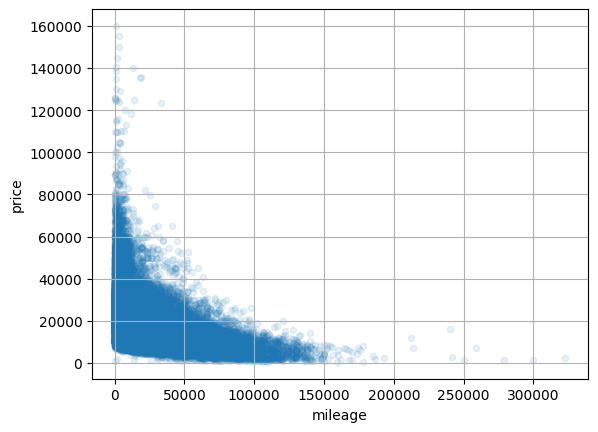

In [164]:
car_price_data_df.plot(
    kind='scatter', 
    x='mileage', 
    y='price',
    alpha=0.1,
    grid=True
)

#### Observations
1. All features show correlation with price
2. Suprisingly, engine size appears to have the strongest correlation with price of all features
3. Year and mileage appear to have exponential correlations with price
3. There is a correlation between road tax and price, but in the UK road tax cost is based off emissions rates, and engine size so there is potentially some overlap of this feature with engine size and mpg


## Data Cleaning

In [89]:
# Create a clean training set by copying original and remove labels
car_price_data = train_set.copy()

# Create labels dataset for the training set
car_price_data_labels = train_set['price'].copy()

In [90]:
car_price_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79349 entries, 89591 to 15795
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         79349 non-null  object 
 1   year          79349 non-null  int64  
 2   price         79349 non-null  int64  
 3   transmission  79349 non-null  object 
 4   mileage       79349 non-null  int64  
 5   fuel_type     79349 non-null  object 
 6   road_tax      79349 non-null  int64  
 7   mpg           79349 non-null  float64
 8   engine_size   79349 non-null  float64
 9   make          79349 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 6.7+ MB


The data has no missing values, so no cleaning for missing values is required.

### Encoding Categorical Features

#### One-hot encoding 'make'

In [91]:
car_price_data['make'].value_counts()

make
Ford        14391
Vw          12066
Vauxhall    10886
Merc        10556
Bmw          8617
Audi         8520
Toyota       5437
Skoda        5027
Hyundi       3849
Name: count, dtype: int64

As 'make' has relatively low cardinality, we can use a one-hot encoder to encode this feature.

In [94]:
# Get make categorical data
car_price_data_make = car_price_data[['make']]
# Create one-hot encoder
make_encoder = OneHotEncoder()
# Apply the encoder
car_price_data_make_1hot = make_encoder.fit_transform(car_price_data_make)

#### Target encoding 'model'

In [93]:
car_price_data['model'].value_counts()

model
Fiesta             5208
Golf               3904
Focus              3682
C Class            3011
Corsa              2736
                   ... 
A2                    1
RS7                   1
Amica                 1
Transit Tourneo       1
Streetka              1
Name: count, Length: 193, dtype: int64

As 'model' has high cardinality, we'll use target encoding to prevent inflating the feature space significantly.

### Feature Scaling & Transformation

Create custom transformer to remove any instances where year is in the future

In [165]:
class RemoveFutureYears(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[X['year'] <= 2024] # current year assigned manually as 2024

Create custom transformer to convert feature to log of itself

In [166]:
# Define the function to take the logarithm
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)

Define features for each pipeline

In [167]:
# Numerical features for standard numerical pipeline
num_features = ['road_tax', 'mpg', 'engine_size']
# Numerical features for log pipline
num_log_features = ['mileage', 'year']
# Categorical features for one-hot encoding pipeline
cat_features = ['make', 'transmission', 'fuel_type']
# Categorical features for feature-hashing pipeline
cat_hash_features = ['model']

In [179]:
vehicle_numerical_pipeline = make_pipeline(
    #RemoveFutureYears(),
    SimpleImputer(strategy='median'),
    StandardScaler()
)

vehicle_numerical_log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    #log_transformer,
    StandardScaler()
)

vehicle_cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

vehicle_cat_hash_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    FeatureHasher(n_features=10, input_type='string')
)

preprocessing = ColumnTransformer([
    ('num', vehicle_numerical_pipeline, num_features),
    ('num_log', vehicle_numerical_log_pipeline, num_log_features),
    ('cat_one_hot', vehicle_cat_pipeline, cat_features),
    ('cat_hash', vehicle_cat_hash_pipeline, cat_hash_features),
])

In [180]:
# Get clean copy of training data
car_price_data = train_set.drop("price", axis=1)
car_price_data_labels = train_set["price"].copy()

In [181]:
car_price_data_prepared = preprocessing.fit_transform(car_price_data)

In [182]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(car_price_data, car_price_data_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['road_tax', 'mpg',
                                                   'engine_size']),
                                                 ('num_log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['mileage', 'year'])...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['make', 'transmission',
                                                   'fuel_type']),
                                                 ('cat_hash',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('featurehasher',
                                                                   FeatureHasher(input_type='string',
                                                                                 n_features=10))]),
                                                  ['model'])])),
                ('linearregression', LinearRegression())])

In [183]:
from sklearn.model_selection import cross_val_score

lin_reg_rmses = -cross_val_score(lin_reg, car_price_data, car_price_data_labels, scoring="neg_root_mean_squared_error", cv=10)

In [184]:
pd.Series(lin_reg_rmses).describe()

count      10.000000
mean     4705.682344
std       217.097938
min      4360.321784
25%      4653.106944
50%      4677.037322
75%      4787.368248
max      5128.100795
dtype: float64

In [185]:
lin_reg.score(car_price_data, car_price_data_labels)

0.7727190677065939

Decision Tree

In [186]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(car_price_data, car_price_data_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['road_tax', 'mpg',
                                                   'engine_size']),
                                                 ('num_log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['mileage', 'year'])...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['make', 'transmission',
                                                   'fuel_type']),
                                                 ('cat_hash',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('featurehasher',
                                                                   FeatureHasher(input_type='string',
                                                                                 n_features=10))]),
                                                  ['model'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [189]:
tree_rmses = -cross_val_score(tree_reg, car_price_data, car_price_data_labels, scoring="neg_root_mean_squared_error", cv=10)

In [190]:
pd.Series(tree_rmses).describe()

count      10.000000
mean     2587.560826
std       265.795695
min      2369.972133
25%      2410.567542
50%      2510.878241
75%      2654.204205
max      3270.086894
dtype: float64

Mileage and year roughly follow power law, so we will compute their log to get something closer to a gaussian distribution.

In [99]:
car_price_data['mileage_log'] =  np.log(car_price_data['mileage'])

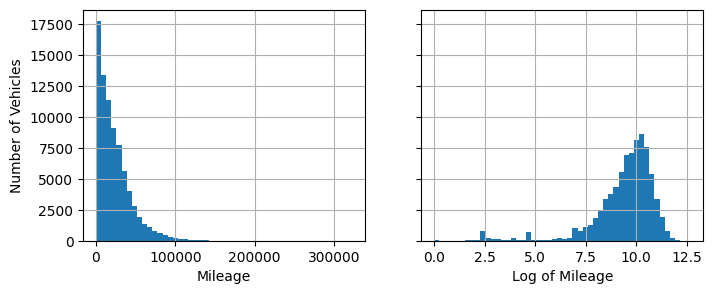

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
car_price_data["mileage"].hist(ax=axs[0], bins=50)
car_price_data["mileage_log"].hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Mileage")
axs[1].set_xlabel("Log of Mileage")
axs[0].set_ylabel("Number of Vehicles")
plt.show()

In [101]:
car_price_data['year_log'] =  np.log(car_price_data['year'])

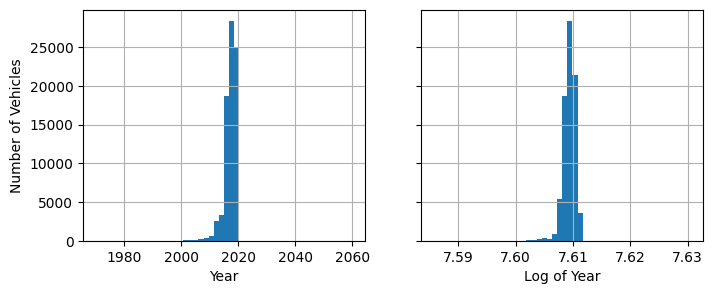

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
car_price_data["year"].hist(ax=axs[0], bins=50)
car_price_data["year_log"].hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Year")
axs[1].set_xlabel("Log of Year")
axs[0].set_ylabel("Number of Vehicles")
plt.show()